In [2]:
import os
import cv2
import numpy as np
import SimpleITK as sitk
from glob import glob
import matplotlib.pyplot as plt

# visualize the ct data

In [57]:
data_root = '/home/zyi/PycharmProjects/Med_Seg/datasource/LITS/Training Batch'
volume_lits = glob(os.path.join(data_root, 'volume-*.nii'))
volume_lits = sorted(volume_lits, key=lambda x: int(x.split('-')[-1].split('.')[0]))

In [58]:
volume = sitk.ReadImage(volume_lits[0])
mask = sitk.ReadImage(volume_lits[0].replace('volume', 'segmentation'))

volume_array = sitk.GetArrayFromImage(volume)
mask_array = sitk.GetArrayFromImage(mask)

print("volume array shape: ", volume_array.shape)
print("volume spacing: ", volume.GetSpacing())

print("mask array shape: ", mask_array.shape)
print("mask spacing: ", mask.GetSpacing())

assert volume_array.shape[0] == mask_array.shape[0], 'unmatched dimension of volume and mask data'

volume array shape:  (75, 512, 512)
volume spacing:  (0.703125, 0.703125, 5.0)
mask array shape:  (75, 512, 512)
mask spacing:  (0.703125, 0.703125, 5.0)


In [59]:
volume_array[volume_array > 250] = 250
volume_array[volume_array < -150] = -150

# exclude background slices
slice_index = np.any(mask_array, axis=(1, 2))
start_slice, end_slice = np.where(slice_index)[0][[0, -1]]   # slices contain liver
print("start_slice: ", start_slice)
print("end_slice: ", end_slice)

expand_slice = 5
if start_slice - expand_slice < 0:
    start_slice = 0
else:
    start_slice -= expand_slice
    
if end_slice + expand_slice >= volume_array.shape[0]:
    end_slice = volume_array.shape[0]-1
else:
    end_slice += expand_slice 

new_volume_array = volume_array[start_slice:end_slice, :, :]
new_mask_array = mask_array[start_slice:end_slice, :, :]


start_slice:  45
end_slice:  73


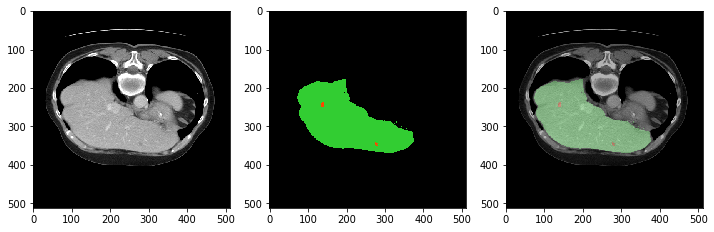

In [92]:
index =26
image = new_volume_array[index, :, :]      # float32
mask = new_mask_array[index, :, :]         # int16

image = (255*((image - np.min(image)) / (np.max(image) - np.min(image)))).astype(np.uint8) # normalize image value to 0~255

mask[mask == 1] = 128
mask[mask == 2] = 255

# overlaid image and mask
image_color = np.stack((image, image, image), axis=2)
mask_color = np.stack((mask, mask, mask), axis=2)

mask_color[:, :, 0] = np.where(mask_color[:, :, 0] == 128, 50, mask_color[:, :, 0])
mask_color[:, :, 1] = np.where(mask_color[:, :, 1] == 128, 205, mask_color[:, :, 1])
mask_color[:, :, 2] = np.where(mask_color[:, :, 2] == 128, 50, mask_color[:, :, 2])

mask_color[:, :, 0] = np.where(mask_color[:, :, 0] == 255, 255, mask_color[:, :, 0])
mask_color[:, :, 1] = np.where(mask_color[:, :, 1] == 255, 69, mask_color[:, :, 1])
mask_color[:, :, 2] = np.where(mask_color[:, :, 2] == 255, 0, mask_color[:, :, 2])

overlaid_img_msk = 0.7*image_color + 0.3*mask_color

fig, axes = plt.subplots(1, 3, figsize=(12,36))
axes[0].imshow(image, cmap='gray')
axes[1].imshow(mask_color)
axes[2].imshow(overlaid_img_msk.astype(np.uint8))

plt.show()